# Gaze Interception
This notebook takes in two files taken from the Pupil Recordings you have exported in Pupil Player. These are:
- `gaze_positions.csv` (contains raw data in regards to the gaze made throughout the recording)
- `info.player.json` (contains system and sync time used to format the recording timestamps)

In [116]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import json
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
# File Paths
info_player_filePath = 'source/info.player.json'
gaze_csv_filePath = 'source/gaze_positions.csv'
annotations_filepath = 'source/annotations.csv'

In [117]:
# Helper Functions

# Calculate angular distance given Cartesian coordinates (x, y)
def calculate_angular_distance(x, y):
    return np.arctan2(y, x)

# Calculate velocity given angular distance and corresponding timestamps.
def calculate_velocity(angular_distance, timestamp):
    time_diff = np.diff(timestamp)
    angular_distance_diff = np.diff(angular_distance)
    velocity = angular_distance_diff / time_diff
    return np.concatenate(([np.nan], velocity))

Reading the `info.player` JSON to retrieve `start_time_synced_s` and `start_time_system_s`. This is used to format the timestamp correctly to indicate time throughout the experiment:

In [118]:
with open(info_player_filePath, 'r') as file:
    data = json.load(file)

start_time_synced_s = data.get('start_time_synced_s')
start_time_system_s = data.get('start_time_system_s')

offset = start_time_system_s - start_time_synced_s
print(f"Offset between system and synced start time: {offset}")

Offset between system and synced start time: 1709032090.0733275


Reading the `gaze_position.csv`, reformatting the timestamps into seconds starting at 0:

In [119]:
gaze_df = pd.read_csv(gaze_csv_filePath)
print(f"There is a total of {len(gaze_df)} in the Gaze DataFrame")

# Converting timestamps into time (starting from 0)
def convert_timestamps_to_time(df, timestamp_column, offset):
    df.copy()
    df['time'] = df[timestamp_column] + offset
    df['time'] -= df['time'].min()
    return df

gaze_df = convert_timestamps_to_time(gaze_df, 'gaze_timestamp', offset)
print(gaze_df['time'])

There is a total of 10105 in the Gaze DataFrame
0         0.000000
1         0.003984
2         0.007891
3         0.011800
4         0.015807
           ...    
10100    45.084119
10101    45.088165
10102    45.092129
10103    45.096095
10104    45.100132
Name: time, Length: 10105, dtype: float64


Smoothing `norm_pos_x` and `norm_pos_y` and plotting on a Position x Time graph:

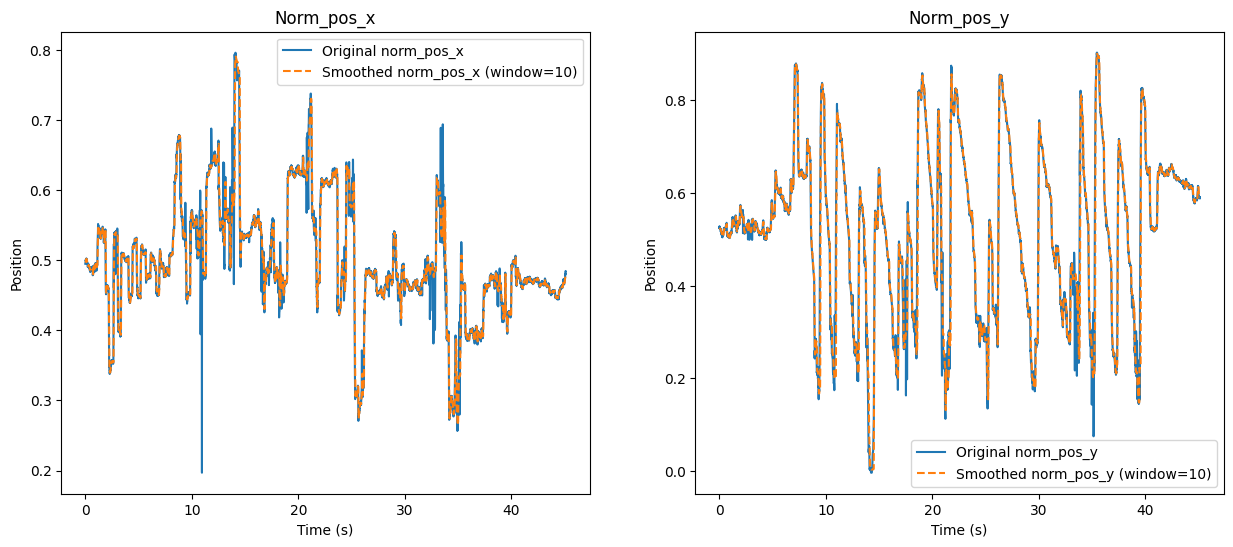

In [120]:
window_size = 10
gaze_df['smoothed_norm_pos_x'] = gaze_df['norm_pos_x'].rolling(window=window_size).median()
gaze_df['smoothed_norm_pos_y'] = gaze_df['norm_pos_y'].rolling(window=window_size).median()

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(gaze_df['time'], gaze_df['norm_pos_x'], label='Original norm_pos_x')
axs[0].plot(gaze_df['time'], gaze_df['smoothed_norm_pos_x'], label=f'Smoothed norm_pos_x (window={window_size})', linestyle='--')
axs[0].set_title('Norm_pos_x')

axs[1].plot(gaze_df['time'], gaze_df['norm_pos_y'], label='Original norm_pos_y')
axs[1].plot(gaze_df['time'], gaze_df['smoothed_norm_pos_y'], label=f'Smoothed norm_pos_y (window={window_size})', linestyle='--')
axs[1].set_title('Norm_pos_y')

for ax in axs:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position')
    ax.legend()

# Plotting Angular Distance agaisnt Time

Calculating `angular_distance` of using normalised `x` and `y` (both smoothed and unsmoothed): 

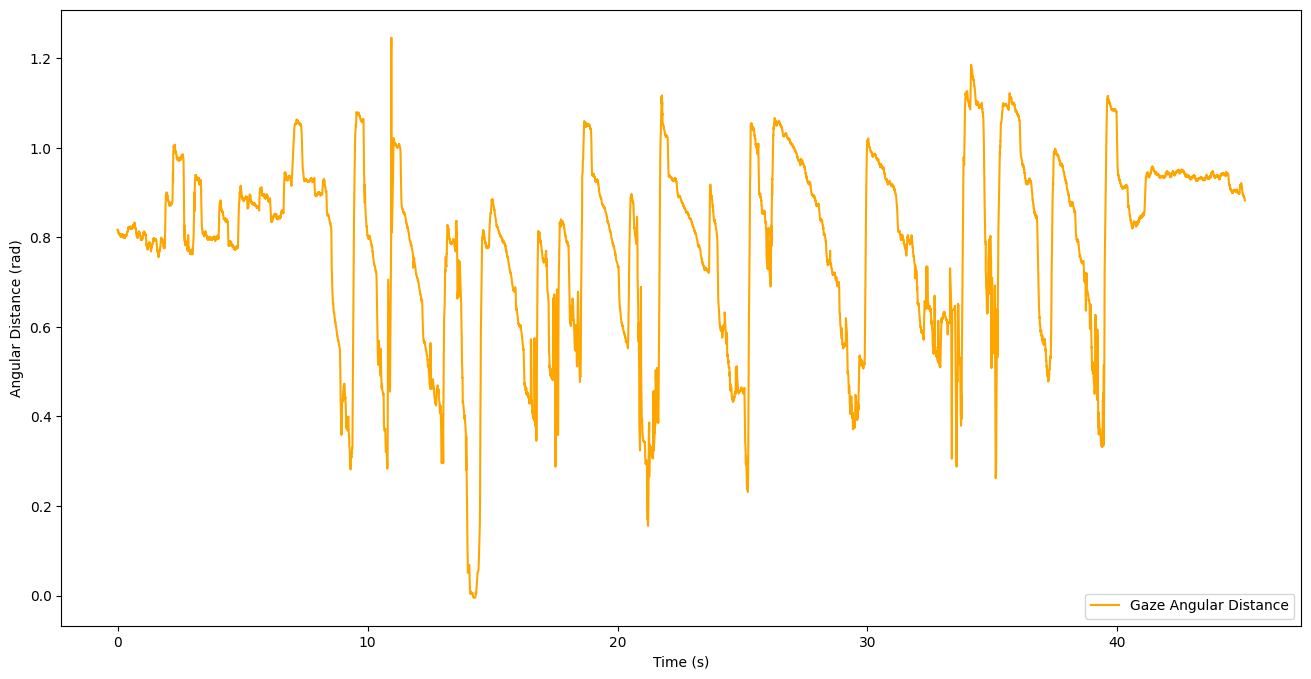

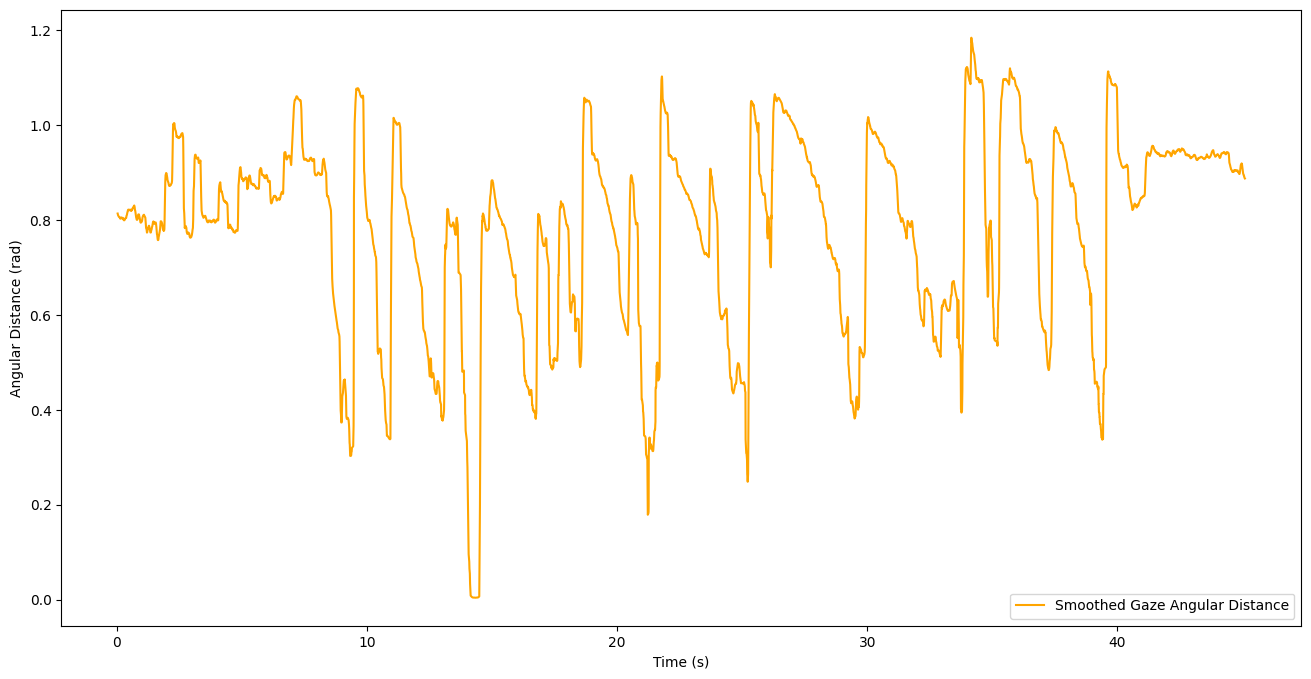

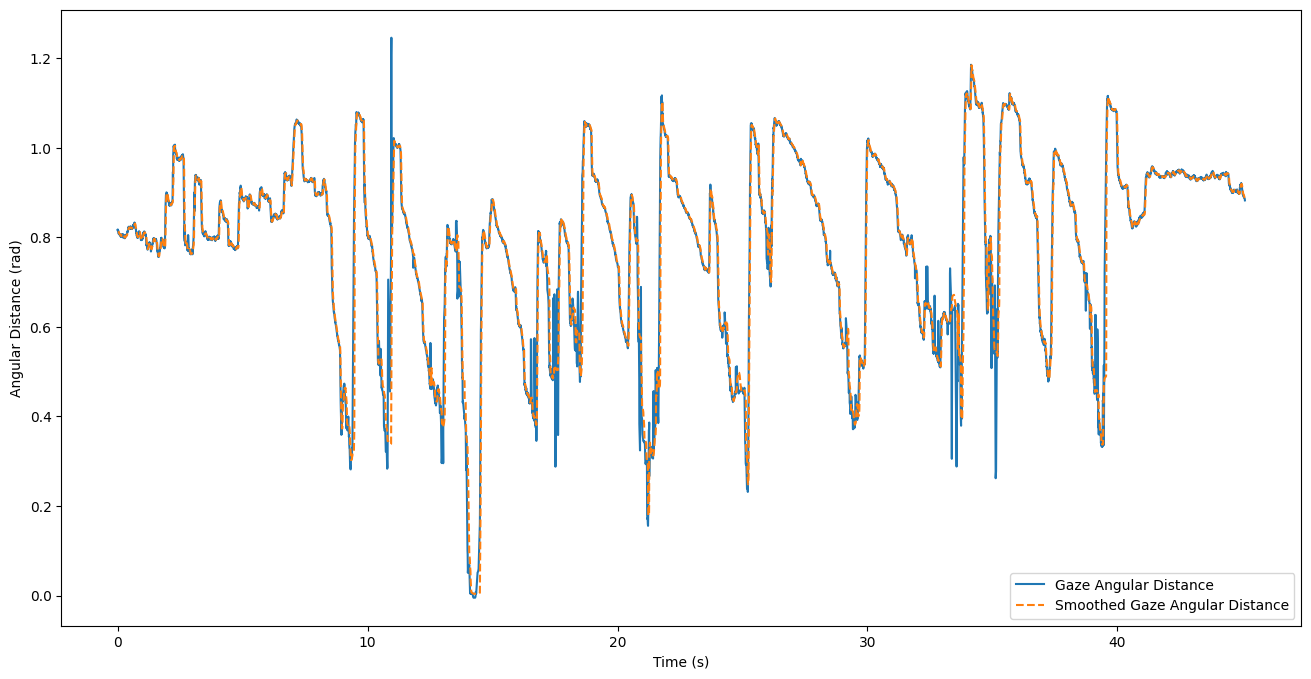

In [121]:
gaze_df['angular_distance'] = calculate_angular_distance(gaze_df['norm_pos_x'], gaze_df['norm_pos_y'])
gaze_df['smoothed_angular_distance'] = calculate_angular_distance(gaze_df['smoothed_norm_pos_x'], gaze_df['smoothed_norm_pos_y'])

# Defining a graph to work with throughout the script:
figure, ax = plt.subplots(figsize=(16, 8))
smoothed_figure, ax2 = plt.subplots(figsize=(16, 8))

# Plot angular distance data from a DataFrame against time.
def plot_angular_graph(ax, df, source='angular_distance', show_both=False):

    if show_both:
        ax.plot(df['time'], df['angular_distance'], label='Gaze Angular Distance',)
        ax.plot(df['time'], df['smoothed_angular_distance'], label=f'Smoothed Gaze Angular Distance', linestyle='--')
    
    else:
        if source == 'smoothed_angular_distance':
            ax.plot(df['time'], df['smoothed_angular_distance'], label=f'Smoothed Gaze Angular Distance', color='orange')
        else:
            ax.plot(df['time'], df['angular_distance'], label='Gaze Angular Distance', color='orange')

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Angular Distance (rad)', color='black')

    ax.legend(loc='lower right')
    fig.suptitle('Interception Experiment')

plot_angular_graph(ax, gaze_df)
plot_angular_graph(ax2, gaze_df, source='smoothed_angular_distance')

combined_figure, ax3 = plt.subplots(figsize=(16, 8))
plot_angular_graph(ax3, gaze_df, show_both=True)


# Identifying Saccadic Movements
Based on the research from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1190820/pdf/jphysiol00502-0164.pdf, Saccadic Movements have a stereotypical velocity graph where large peaks indicates a fast movement between two points (saccades). These are almost like straight lines between points.

Calculating the gradient (velocity) at each point of the graph:

We create a new column in the `gaze_df` dataframe where it calculates the angular velocity using the `time` and `angular_distance` between each point

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
10100   -0.135143
10101   -0.091409
10102   -0.035768
10103   -0.098599
10104   -0.116343
Name: smoothed_angular_velocity, Length: 10105, dtype: float64
0             NaN
1        0.104122
2       -0.908235
3        0.012869
4        0.164038
           ...   
10100   -0.014450
10101   -0.172725
10102   -0.076717
10103   -0.478626
10104   -0.511961
Name: angular_velocity, Length: 10105, dtype: float64


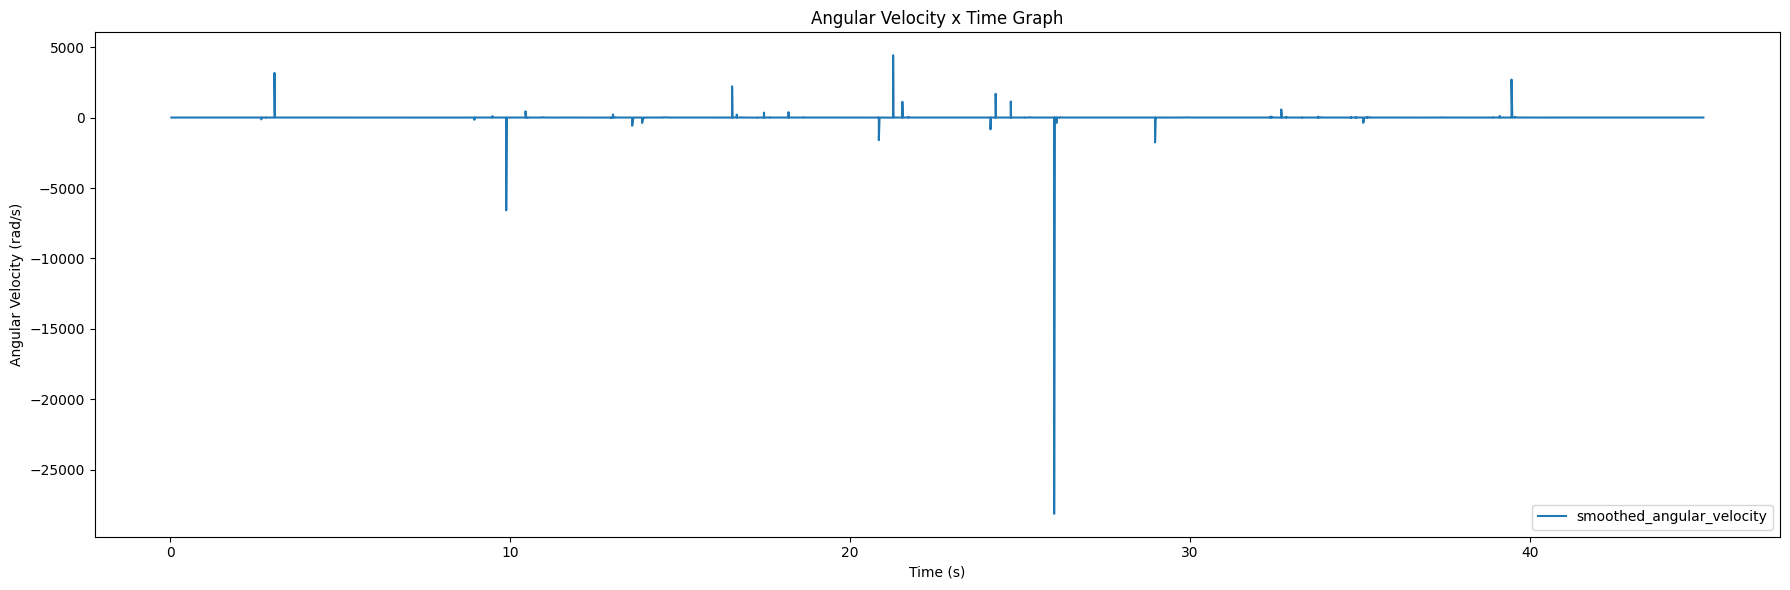

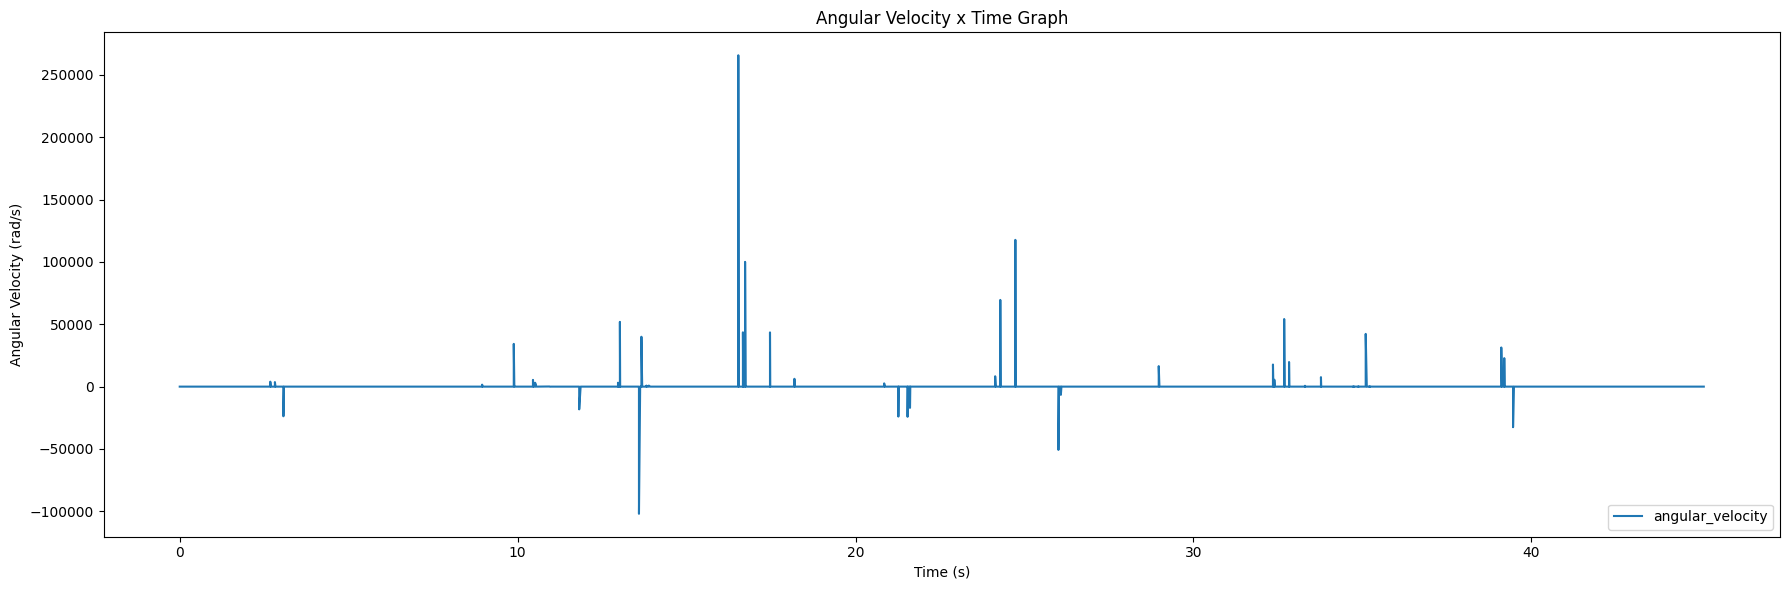

In [122]:
gaze_df['angular_velocity'] = calculate_velocity(gaze_df['angular_distance'], gaze_df['time'])
gaze_df['smoothed_angular_velocity'] = calculate_velocity(gaze_df['smoothed_angular_distance'], gaze_df['time'])

def plot_velocity_graph(df, source='angular_velocity'):
    print(df[source])
    """
    Plot angular velocity data from a DataFrame against time.

    Parameters:
        df: DataFrame containing angular velocity data.
        source (str): Source of angular velocity data ('angular_velocity' by default).

    """

    plt.figure(figsize=(18, 6))
    plt.plot(df['time'], df[source], label=f'{source}',)

    plt.title('Angular Velocity x Time Graph')
    plt.xlabel('Time (s)')
    plt.ylabel('Angular Velocity (rad/s)')
    # plt.ylabel('Gaze Position')

    plt.legend(loc='lower right')
    plt.tight_layout()

plot_velocity_graph(gaze_df, 'smoothed_angular_velocity')
plot_velocity_graph(gaze_df)

Identifying regions of high velocity (when a velocity at a point exceeds a threshold) and plot saccadic movements on the Angular Distance Time Graph:

`plot_saccade_graph` takes a column from the DataFrame (`angular_velocity` or `smoothed_angular_velocity`) and plots it agaisnt time.
The parameter `show_velocity` allows to display the velocity graph (same as above) under the main graph

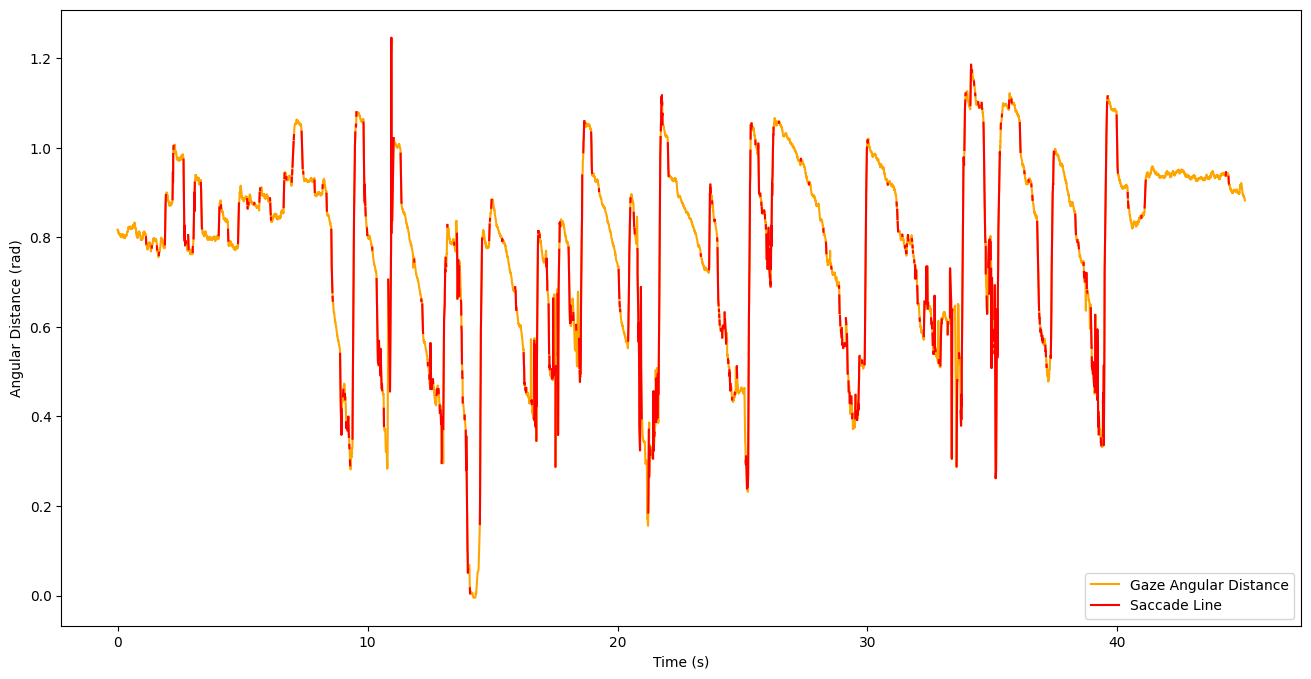

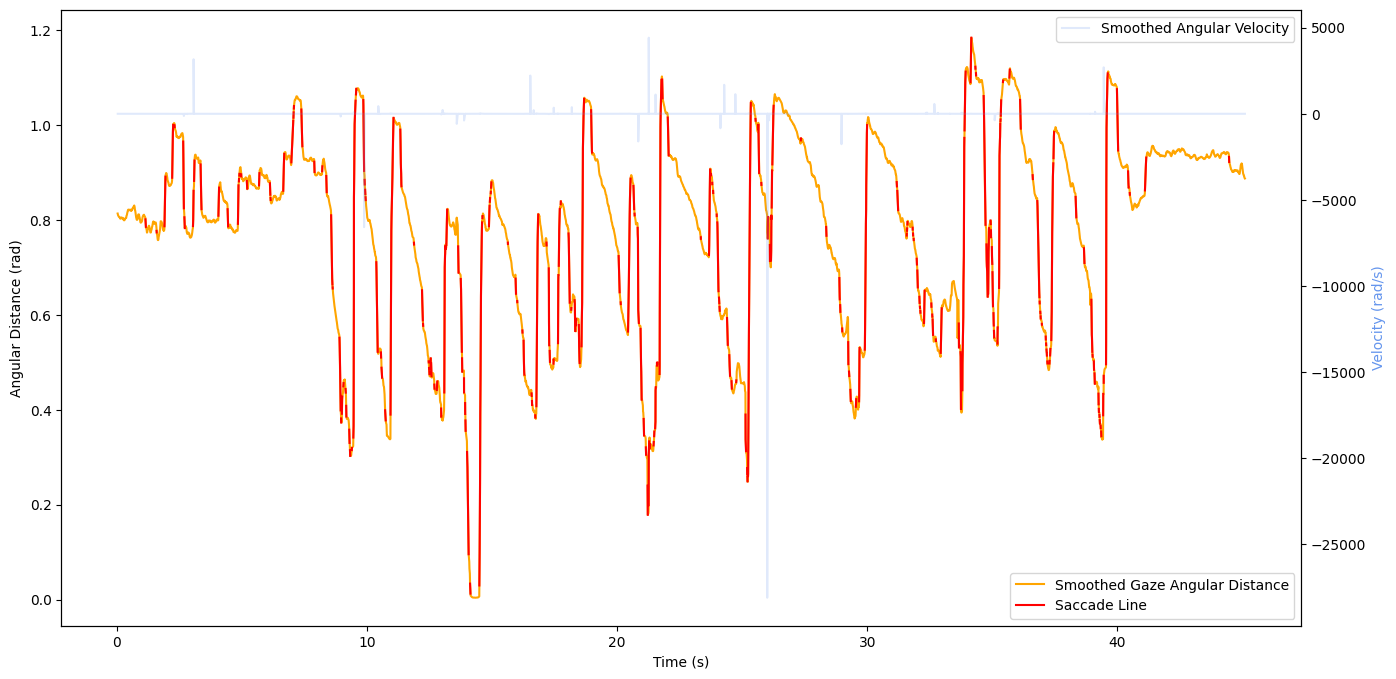

In [123]:
def plot_saccade_graph(ax, df, source='angular_velocity', threshold_velocity=0.8, show_velocity=False):
    """
    Plot saccade-related data from a DataFrame agaisnt time. And optionally show the velocity graph under.

    Parameters:
        fig : The Figure object to plot on.
        ax : The primary Axes object to plot on.
        df : DataFrame containing saccade-related data.
        source (str): Source of data ('angular_velocity' or 'smoothed_angular_velocity' by default).
        threshold_velocity (float): Threshold for identifying saccades based on velocity.
        show_velocity (bool): Whether to show velocity data on the plot.
    """
    velocity_label = "Angular Velocity"
    source_angular = gaze_df['angular_distance']
    source_velocity = gaze_df['angular_velocity']

    saccade_regions_high = df[source] > threshold_velocity
    accade_regions_low = df[source] < -threshold_velocity
    saccade_regions = saccade_regions_high | accade_regions_low


    if (source == 'smoothed_angular_velocity'):
        source_angular = gaze_df['smoothed_angular_distance']
        source_velocity = gaze_df['smoothed_angular_velocity']
        velocity_label = "Smoothed Angular Velocity"
        angular_label = "Smoothed Angular Distance"
    else:
        source_angular = gaze_df['angular_distance']
        source_velocity = gaze_df['angular_velocity']

    
    # Plot for Unsmoothed Data
    ax.plot(gaze_df['time'], np.where(saccade_regions, source_angular, np.nan), color='red', label='Saccade Line')
    ax.legend(loc='lower right')

    if show_velocity:
        ax1_2 = ax.twinx()
        ax1_2.plot(gaze_df['time'], source_velocity, label=f'{velocity_label}', linestyle='-', color='cornflowerblue', alpha=0.2)
        ax1_2.set_ylabel('Velocity (rad/s)', color='cornflowerblue')
        ax1_2.legend(loc='upper right')

    # Set common title
    fig.suptitle('Interception Experiment')

vel_ang_fig, ax = plt.subplots(figsize=(16, 8))
plot_angular_graph(ax, gaze_df)
plot_saccade_graph(ax, gaze_df)

vel_ang_fig_smoothed, ax1_2 = plt.subplots(figsize=(16, 8))
plot_angular_graph(ax1_2, gaze_df, source='smoothed_angular_distance')
plot_saccade_graph(ax1_2, gaze_df, source='smoothed_angular_velocity', show_velocity=True)


# Identifying Smooth Pursuit
Smooth pursuit occurs when the eyes tracks an moving object at a constant speed. There is roughly a constant velocity as the angular distance changes slowly, whereas Saccades are almost instant. We choose regions of the line where the change in velocity is under a threshold, and the change of angular distance is small enough to indicate the eyes moving between positions slowly.

`plot_smooth_pursuit_graph` takes a column from the DataFrame (`angular_velocity` or `smoothed_angular_velocity`) and plots it agaisnt time.
The parameter `show_velocity` allows to display the velocity graph (same as above) under the main graph

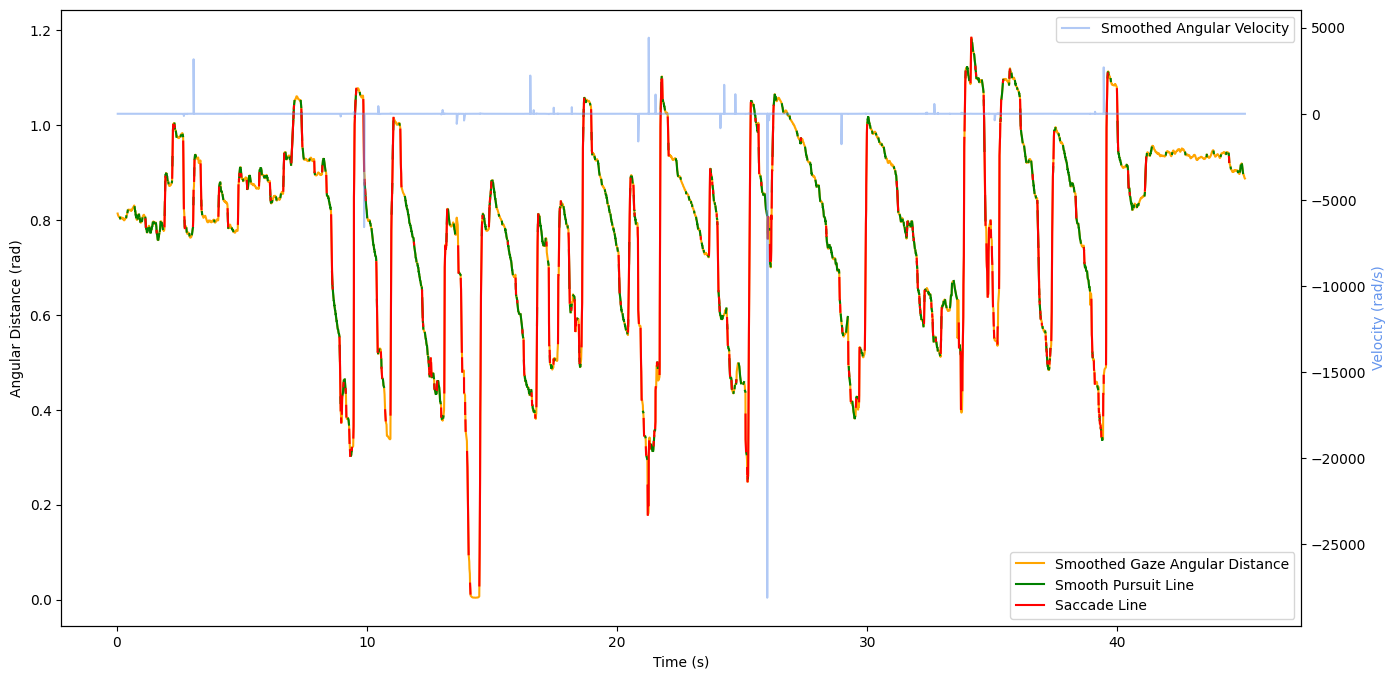

In [124]:
def plot_smooth_pursuit_graph(ax, df, source='angular_velocity', velocity_tolerance=0.5, angular_distance_threshold=0.001, show_velocity=False):
    """
    Plot smooth pursuit-related data from a DataFrame against time. And optionally show the velocity graph under.

    Parameters:
        fig : The Figure object to plot on.
        ax : The primary Axes object to plot on.
        df : DataFrame containing smooth pursuit-related data.
        source (str): Source of data ('smoothed_angular_velocity' or 'smoothed_angular_distance' by default).
        velocity_tolerance (float): Tolerance for velocity changes to identify smooth pursuit.
        angular_distance_threshold (float): Threshold for identifying angular distance changes in pursuit.
        show_velocity (bool): Whether to show velocity data on the plot.
    """
    velocity_label = "Angular Velocity"
    source_angular = gaze_df['angular_distance']
    source_velocity = gaze_df['smoothed_angular_velocity']

    if (source == 'smoothed_angular_velocity'):
        source_angular = gaze_df['smoothed_angular_distance']
        source_velocity = gaze_df['smoothed_angular_velocity']
        velocity_label = "Smoothed Angular Velocity"
    else:
        source_angular = gaze_df['angular_distance']
        source_velocity = gaze_df['angular_velocity']


    # Identify periods of smooth pursuit based on velocity and angular distance
    velocity_changes = np.abs(np.gradient(source_velocity))
    angular_distance_changes = np.abs(np.gradient(source_angular))

    pursuit_regions = (velocity_changes < velocity_tolerance) & (angular_distance_changes > angular_distance_threshold)

    # Plot for Smooth Pursuit Data
    ax.plot(df['time'], np.where(pursuit_regions, source_angular, np.nan), color='green', label='Smooth Pursuit Line')
    ax.legend(loc='upper left')

    if show_velocity:
        ax1_2 = ax.twinx()
        ax1_2.plot(df['time'], source_velocity, label=f'{velocity_label}', linestyle='-', color='cornflowerblue', alpha=0.5)
        ax1_2.set_ylabel('Velocity (rad/s)', color='cornflowerblue')
        ax1_2.legend(loc='upper right')

# Example usage for smooth pursuit
smooth_pursuit_fig, ax_smooth_pursuit = plt.subplots(figsize=(16, 8))
plot_angular_graph(ax_smooth_pursuit, gaze_df, source='smoothed_angular_distance')
plot_smooth_pursuit_graph(ax_smooth_pursuit, gaze_df, source='smoothed_angular_velocity', show_velocity=True)
plot_saccade_graph(ax_smooth_pursuit, gaze_df, source='smoothed_angular_velocity')


# Adding Annotations to the graph
To identify when the experiment occurs within the recording, as well as when object spawned and intercepted, we use the `annotations.csv` file:

`add_annotations` looks at a gieven filepath to an `annotation_csv` file and uses `labels` and `timestamp` to determine where to plot events on a Angular Distance Time Graph

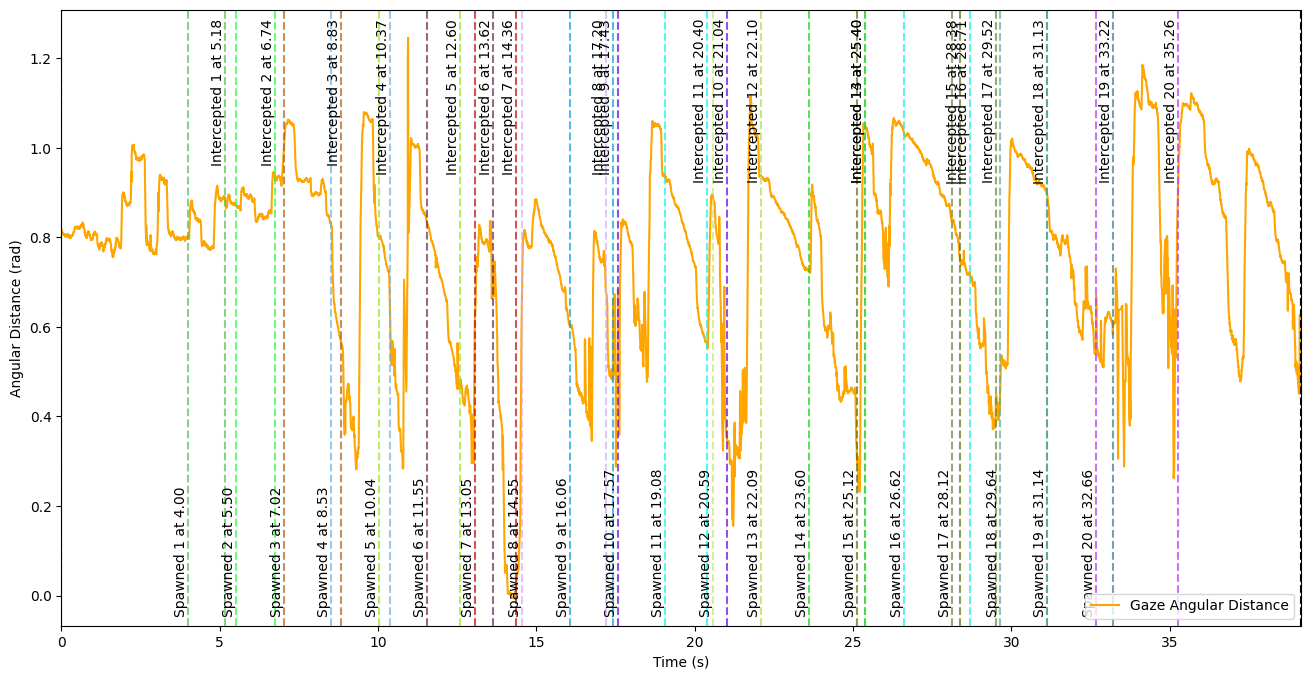

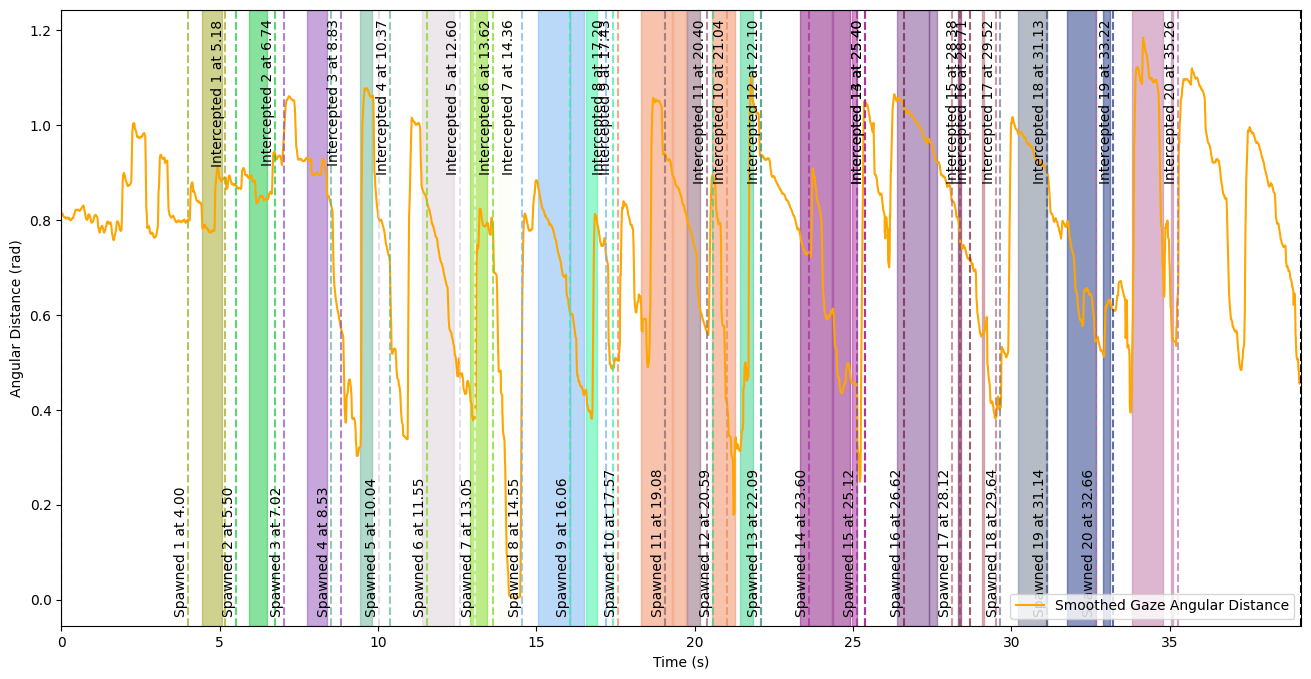

In [125]:
# Generate a random RGB color tuple.
def generate_random_color():
    return (random.random(), random.random(), random.random())

# Draw lines and labels representing spawned objects and interceptions on the given axis.
def draw_objects_and_interceptions(ax, spawn_timestamps, interception_timestamps, annotations_df, obstacle_ids):
    object_colors = {}

    # Handle Spawning annotations
    for timestamp, obj_id in zip(spawn_timestamps, annotations_df.loc[annotations_df['label'] == ('Spawning'), 'id']):

        # Checks if the current annotation is refering to an Obstacle objectType by filtering the annotations_df for the Object ID and retrieving the first 'objectType' (which there should only be one)
        obj_type = annotations_df.loc[(annotations_df['label'] == 'Spawning') & (annotations_df['id'] == obj_id), 'objectType'].values[0] if 'objectType' in annotations_df.columns else None
        if obj_type == 'Obstacle' and obj_id in obstacle_ids:
            draw_object_line(ax, timestamp, obj_id, object_colors, is_interception=False)

    # Handle Interception annotations
    for timestamp, obj_id in zip(interception_timestamps, annotations_df.loc[annotations_df['label'] == 'Intercepted', 'id']):
        obj_type = annotations_df.loc[(annotations_df['label'] =='Intercepted') & (annotations_df['id'] == obj_id),'objectType'].values[0] if 'objectType' in annotations_df.columns else None
        # There is a chance for an interception to be missed, so if there exists no records for the ID with label 'Intercepted' then there would be no object type to use, therefore don't need to plot
        
        if obj_type == 'Obstacle' and obj_id in obstacle_ids:
            draw_object_line(ax, timestamp, obj_id, object_colors, is_interception=True)

    return object_colors

# Draw vertical lines on the given axis to represent the start and end of an experiment and scale the x axis to those timestamps
def draw_experiment_lines(ax, start_timestamp, end_timestamp):
    ax.axvline(x=start_timestamp, color='black', linestyle='--')
    ax.axvline(x=end_timestamp, color='black', linestyle='--')
    ax.set_xlim(start_timestamp, end_timestamp)

# Draw a vertical line on the given axis to represent an object and add a text label.
def draw_object_line(ax, timestamp, obj_id, object_colors, is_interception):
    # Assign a random RGB color if ID doesn't have one
    object_colors.setdefault(obj_id, generate_random_color())

    # Get the line color
    line_color = object_colors[obj_id]

    # Determine the vertical alignment and position
    vertical_alignment = 'top' if is_interception else 'bottom'
    vertical_position = ax.get_ylim()[0] + 0.02 if vertical_alignment == 'bottom' else ax.get_ylim()[1] - 0.02

    # Plot a vertical line
    ax.axvline(x=timestamp, color=line_color, linestyle='--', alpha=0.7)

    # Add text label
    label_text = f'{"Intercepted" if is_interception else "Spawned"} {int(obj_id)} at {timestamp:.2f}'
    ax.text(timestamp, vertical_position, label_text, rotation=90, va=vertical_alignment, ha='right', color='black')


# Plot regions on the given axis, using colors based on the object_colors dictionary for each object ID.
def plot_observations(ax, annotations_df, object_colours, fill_threshold=1.0):
    looking_at_df = annotations_df.loc[annotations_df['label'] == 'Looking At'].copy()

    # Create an empty dictionary to store the regions for each object ID
    id_region_dict = {}

    # Initialise variables for tracking consecutive points
    current_obj_id = None
    start_time = None

    # Iterate through each row in the 'Looking At' dataframe
    for _, row in looking_at_df.iterrows():
        obj_id = row['id']
        timestamp = row['time']

        # Check if it's the same object and within the threshold seconds
        if obj_id == current_obj_id and start_time is not None and timestamp - start_time <= fill_threshold: 
            end_time = timestamp # Update the end time for the current region
        else:
            # A new region is created when the next ID does not match the current region's ID OR if the time between two points is greater than the threshold (indicating it's a new region for the same ID)
            if current_obj_id is not None and start_time is not None:
                if current_obj_id not in id_region_dict: # If an ID has not been given regions, this will make sure that it has been intialised before we can add new regions
                    id_region_dict[current_obj_id] = [] 
                id_region_dict[current_obj_id].append((start_time, end_time)) # Adds this region to the key with the Object ID

            # Update tracking variables for the next iteration
            current_obj_id = obj_id
            start_time = timestamp
            end_time = timestamp

    # Add the last region after the loop
    if current_obj_id is not None and start_time is not None:
        if current_obj_id not in id_region_dict:
            id_region_dict[current_obj_id] = []
        id_region_dict[current_obj_id].append((start_time, end_time))

    # Iterates through each key-value pair
    for obj_id, regions in id_region_dict.items():
        color = object_colours[obj_id] # Retrieves the colour of the current object from the dictionary

        for region in regions: # Each region should have a start time, and an end time. We iterate through each one whiles also colouring the region between them
            start_time, end_time = region
            ax.axvspan(start_time, end_time, color=color, alpha=0.5, label=f'Object ID {obj_id}')

# Add annotations to a given plot.
def add_annotations(ax, filepath='annotations.csv', show_observable=False):
    if filepath:
        # Creates a DataFrame containing all the annotation data, and also creating a new field called 'Time' which format timestamps into the corresponding time of the recording
        annotations_df = pd.read_csv(filepath)
        annotations_df = convert_timestamps_to_time(annotations_df, 'timestamp', offset)

        # Filter annotations for 'Spawning' or 'Intercepted' labels and ObjectType 'Obstacle'
        filtered_annotations = annotations_df[
            (annotations_df['label'].isin(['Spawning', 'Intercepted'])) &
            (annotations_df['objectType'] == 'Obstacle')
        ]

        # Identifying different types of annotation to plot on the graph
        spawn_timestamps = filtered_annotations.loc[filtered_annotations['label'] == 'Spawning', 'time'].values
        interception_timestamps = filtered_annotations.loc[filtered_annotations['label'] == 'Intercepted', 'time'].values

        start_timestamp = annotations_df.loc[(annotations_df['label'] == 'Experiment Started'), 'time'].values
        end_timestamp = annotations_df.loc[(annotations_df['label'] == 'Experiment Ended'), 'time'].values

        draw_experiment_lines(ax, start_timestamp, end_timestamp) # Draws a line for when the experiment has started and ended, as well as adjusting the x-axis scale to show only between those points

        # Extract ObjectType 'Obstacle' and ID for plotting
        obstacle_ids = filtered_annotations.loc[:, 'id'].values

        # Each object should be given a colour for their specific ID, this can be used for when we want to show what object the user is currently observing
        object_colors = draw_objects_and_interceptions(ax, spawn_timestamps, interception_timestamps, annotations_df, obstacle_ids)
        
        # This will show regions of which indicates where the user looks at depending on the annotations with the label 'Looking At'
        if show_observable:

            plot_observations(ax, annotations_df, object_colors)

ang_annotation_fig, ax = plt.subplots(figsize=(16, 8))
plot_angular_graph(ax, gaze_df)
add_annotations(ax, annotations_filepath, show_observable=False)

ang_annotation_fig_smoothed, ax1 = plt.subplots(figsize=(16, 8))
plot_angular_graph(ax1, gaze_df, source='smoothed_angular_distance')
add_annotations(ax1,annotations_filepath, show_observable=True)

`plot_experiment` is a function that will use the default paramaters to plot angular distance with identified saccades and smooth pursuit, and annotations. We can choose between smoothed or unsmoothed data, as well as display velocity.

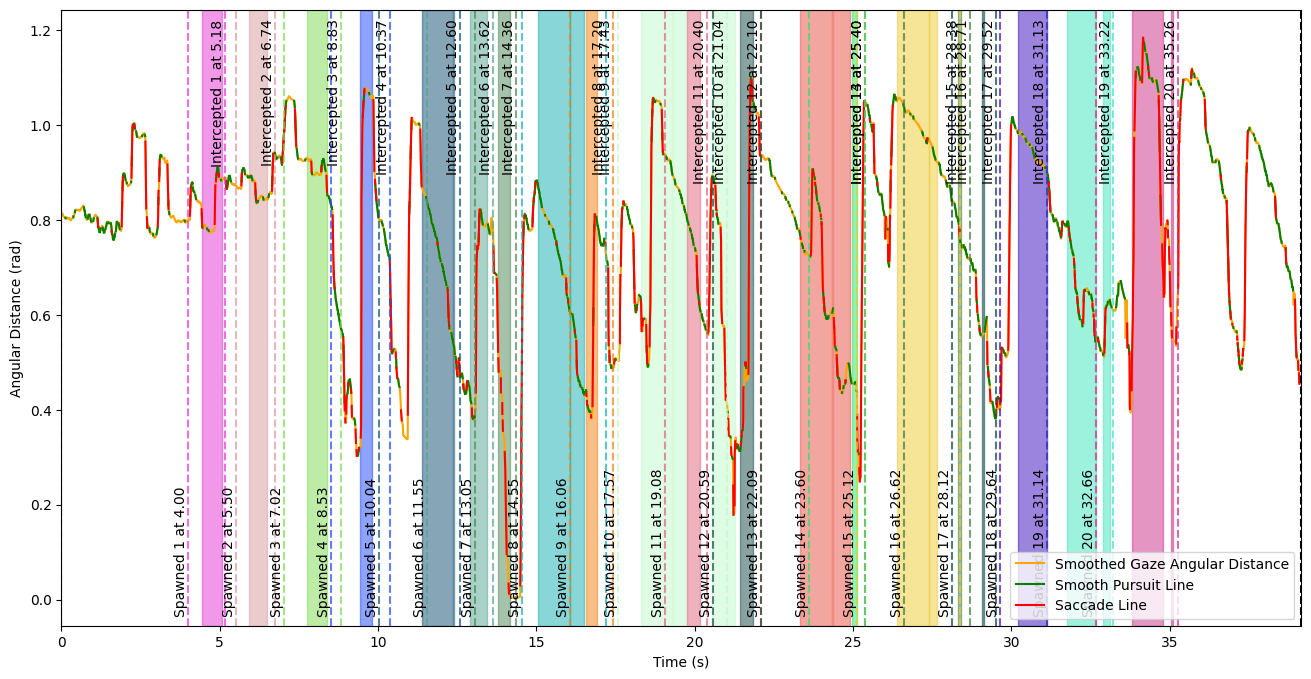

In [126]:
# Plot a combination of angular distance and saccade-related data for an experiment with corresponding annotations base on if they want to use the smoothed or raw data.
def plot_experiment(ax, df, use_smooth=False, show_velocity=False, show_observable=False):
    if use_smooth:
        sourceDistance = 'smoothed_angular_distance'
        sourceVelocity = 'smoothed_angular_velocity'
    else:
        sourceDistance = 'angular_distance'
        sourceVelocity = 'angular_velocity'

    plot_angular_graph(ax, df, sourceDistance)
    plot_smooth_pursuit_graph(ax, df, sourceVelocity)
    plot_saccade_graph(ax, df, sourceVelocity, show_velocity=show_velocity)
    add_annotations(ax, annotations_filepath, show_observable=show_observable)

experiment, exp_ax = plt.subplots(figsize=(16, 8))
plot_experiment(exp_ax, gaze_df, use_smooth=True, show_velocity=False, show_observable=True)